In [ ]:
import os
import cv2
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive (if your dataset is stored there)
# Comment this out if you're uploading the dataset directly to Colab
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/CV_Final

/content/drive/MyDrive/CV_Final


In [ ]:
# !unzip animal_face_dataset.zip -d face_dataset

In [ ]:
def load_images_from_folder(folder, label, num_images):
    images = []
    labels = []
    file_list = os.listdir(folder)

    # Make sure we only get exactly num_images
    file_list = file_list[:num_images]

    for filename in tqdm(file_list, desc=f"Loading {os.path.basename(folder)}"):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    # Resize image to reduce computation time and ensure consistent dimensions
                    img = cv2.resize(img, (256, 256))
                    images.append(img)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    print(f"Loaded {len(images)} images from {folder}")
    return images, labels

def load_dataset(base_path, train_count=200, test_count=50):
    # Load training data
    train_cats_path = os.path.join(base_path, 'train', 'cat')
    train_dogs_path = os.path.join(base_path, 'train', 'dog')

    print("Loading training images...")
    train_cats_images, train_cats_labels = load_images_from_folder(train_cats_path, 0, train_count)
    train_dogs_images, train_dogs_labels = load_images_from_folder(train_dogs_path, 1, train_count)

    # Load validation data
    val_cats_path = os.path.join(base_path, 'val', 'cat')
    val_dogs_path = os.path.join(base_path, 'val', 'dog')

    print("Loading validation images...")
    val_cats_images, val_cats_labels = load_images_from_folder(val_cats_path, 0, test_count)
    val_dogs_images, val_dogs_labels = load_images_from_folder(val_dogs_path, 1, test_count)

    # Combine all training and validation data
    train_images = train_cats_images + train_dogs_images
    train_labels = train_cats_labels + train_dogs_labels

    val_images = val_cats_images + val_dogs_images
    val_labels = val_cats_labels + val_dogs_labels

    print(f"Loaded {len(train_images)} training images and {len(val_images)} validation images")

    return train_images, train_labels, val_images, val_labels

In [ ]:
def extract_sift_features(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Create SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return keypoints, descriptors

def prepare_dataset_with_sift(images):
    all_descriptors = []

    # Extract SIFT descriptors for all images
    print("Extracting SIFT features...")
    for img in tqdm(images, desc="Extracting SIFT features"):
        _, desc = extract_sift_features(img)
        all_descriptors.append(desc if desc is not None else None)

    return all_descriptors

def create_bovw_features(descriptors_list, n_clusters=100):
    # Collect all valid descriptors
    valid_descriptors = [desc for desc in descriptors_list if desc is not None]
    if not valid_descriptors:
        raise ValueError("No valid descriptors found in the dataset")

    # Concatenate all descriptors from the training set
    all_descriptors = np.vstack(valid_descriptors)

    # Create K-means object and fit to the descriptors
    print(f"Clustering {all_descriptors.shape[0]} descriptors into {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)

    return kmeans

def extract_bovw_features(descriptors, kmeans, n_clusters):
    # Initialize the feature vector with zeros
    features = np.zeros(n_clusters)

    if descriptors is not None:
        # Assign each descriptor to a cluster center
        cluster_indices = kmeans.predict(descriptors)

        # Count occurrences of each cluster
        for idx in cluster_indices:
            features[idx] += 1

    # Normalize the features
    if np.sum(features) > 0:
        features = features / np.sum(features)

    return features

# ADD THIS NEW FUNCTION HERE
def visualize_bovw_pipeline(image_index=0, train_images=None, train_labels=None):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    # If images not provided, use a placeholder message
    if train_images is None:
        print("Please provide train_images and train_labels when calling this function.")
        return None, None, None, None

    # Select a single image for visualization
    image = train_images[image_index]
    label = train_labels[image_index]
    label_name = 'cat' if label == 0 else 'dog'

    # Extract SIFT features
    keypoints, descriptors = extract_sift_features(image)

    # Visualize the image with keypoints
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    keypoint_image = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0),
                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(cv2.cvtColor(keypoint_image, cv2.COLOR_BGR2RGB))
    plt.title(f'SIFT Keypoints on {label_name.capitalize()} Image')
    plt.axis('off')

    # Visualize a single SIFT descriptor
    if descriptors is not None and len(descriptors) > 0:
        plt.subplot(2, 2, 2)
        sample_descriptor_idx = 0  # Select the first descriptor
        sample_descriptor = descriptors[sample_descriptor_idx]
        plt.bar(range(128), sample_descriptor)
        plt.title(f'SIFT Descriptor Vector (Keypoint #{sample_descriptor_idx+1})')
        plt.xlabel('Dimension')
        plt.ylabel('Value')

    # Create a small vocabulary for visualization purposes
    n_clusters = 10  # Smaller number for better visualization

    # Get descriptors from a few images for K-means
    sample_size = min(20, len(train_images))
    sample_descriptors = []
    for i in range(sample_size):
        _, desc = extract_sift_features(train_images[i])
        if desc is not None:
            sample_descriptors.append(desc)

    # Concatenate all descriptors
    all_descriptors = np.vstack(sample_descriptors)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)

    # Visualize cluster centers
    plt.subplot(2, 2, 3)
    for i in range(n_clusters):
        plt.plot(kmeans.cluster_centers_[i], label=f'Cluster {i+1}' if i < 3 else "")
    plt.title('K-means Cluster Centers (Visual Vocabulary)')
    plt.xlabel('Dimension')
    plt.ylabel('Value')
    plt.legend(loc='upper right')

    # Create BoVW histogram for the image
    histogram = extract_bovw_features(descriptors, kmeans, n_clusters)

    # Visualize the histogram
    plt.subplot(2, 2, 4)
    plt.bar(range(n_clusters), histogram)
    plt.title(f'BoVW Histogram for {label_name.capitalize()} Image')
    plt.xlabel('Visual Word (Cluster) Index')
    plt.ylabel('Normalized Frequency')

    plt.tight_layout()
    plt.show()

    print(f"Image Label: {label_name}")
    print(f"Number of keypoints detected: {len(keypoints)}")
    print(f"SIFT descriptor shape: {descriptors.shape if descriptors is not None else 'None'}")
    print(f"K-means clusters: {n_clusters}")
    print(f"Histogram shape: {histogram.shape}")

    return keypoints, descriptors, kmeans, histogram

# Complete pipeline
def main():
    from sklearn.cluster import KMeans
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.svm import SVC

    # Load dataset
    base_path = '/content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset'  # Replace with your dataset path
    train_images, train_labels, val_images, val_labels = load_dataset(base_path)

    # OPTIONAL: Add this line to visualize a single image's pipeline (e.g., the first image)
    visualize_bovw_pipeline(0, train_images, train_labels)

    # Extract SIFT features
    train_descriptors = prepare_dataset_with_sift(train_images)
    val_descriptors = prepare_dataset_with_sift(val_images)

    # Create vocabulary using only training data
    n_clusters = 100  # Size of vocabulary (can be tuned)
    kmeans = create_bovw_features(train_descriptors, n_clusters)

    # Extract BoVW features
    print("Creating BoVW features for training images...")
    train_features = np.array([extract_bovw_features(desc, kmeans, n_clusters)
                               for desc in tqdm(train_descriptors, desc="Processing training features")])

    print("Creating BoVW features for validation images...")
    val_features = np.array([extract_bovw_features(desc, kmeans, n_clusters)
                            for desc in tqdm(val_descriptors, desc="Processing validation features")])

    # Train SVM classifier
    print("Training SVM classifier...")
    svm = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
    svm.fit(train_features, train_labels)

    # Predict on validation set with progress bar
    print("Predicting on validation set...")
    val_predictions = []
    for features in tqdm(val_features, desc="Making predictions"):
        pred = svm.predict([features])[0]
        val_predictions.append(pred)

    val_predictions = np.array(val_predictions)

    # Evaluate
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    accuracy = accuracy_score(val_labels, val_predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(val_labels, val_predictions, target_names=['cat', 'dog']))
    print("Confusion Matrix:")
    conf_matrix = confusion_matrix(val_labels, val_predictions)
    print(conf_matrix)

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('BoVW-SIFT Binary Classification Results')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['cat', 'dog'], rotation=45)
    plt.yticks(tick_marks, ['cat', 'dog'])

    # Add text annotations to the confusion matrix
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    return svm, kmeans

In [ ]:
def predict_and_plot(image_path, svm, kmeans, n_clusters=100):
    import matplotlib.pyplot as plt
    import cv2

    # Load and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Image not found or path is incorrect.")

    # Extract SIFT features
    _, descriptors = extract_sift_features(img)

    # Compute BoVW histogram
    features = extract_bovw_features(descriptors, kmeans, n_clusters).reshape(1, -1)

    # Predict label
    predicted_label = svm.predict(features)[0]
    label_name = 'cat' if predicted_label == 0 else 'dog'

    # Convert BGR to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot the image with the predicted label
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {label_name}")
    plt.axis('off')
    plt.show()

    return label_name

Loading training images...


Loading cat:   0%|          | 0/200 [00:00<?, ?it/s]

Loaded 200 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/train/cat


Loading dog:   0%|          | 0/200 [00:00<?, ?it/s]

Loaded 200 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/train/dog
Loading validation images...


Loading cat:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/val/cat


Loading dog:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 50 images from /content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/val/dog
Loaded 400 training images and 100 validation images


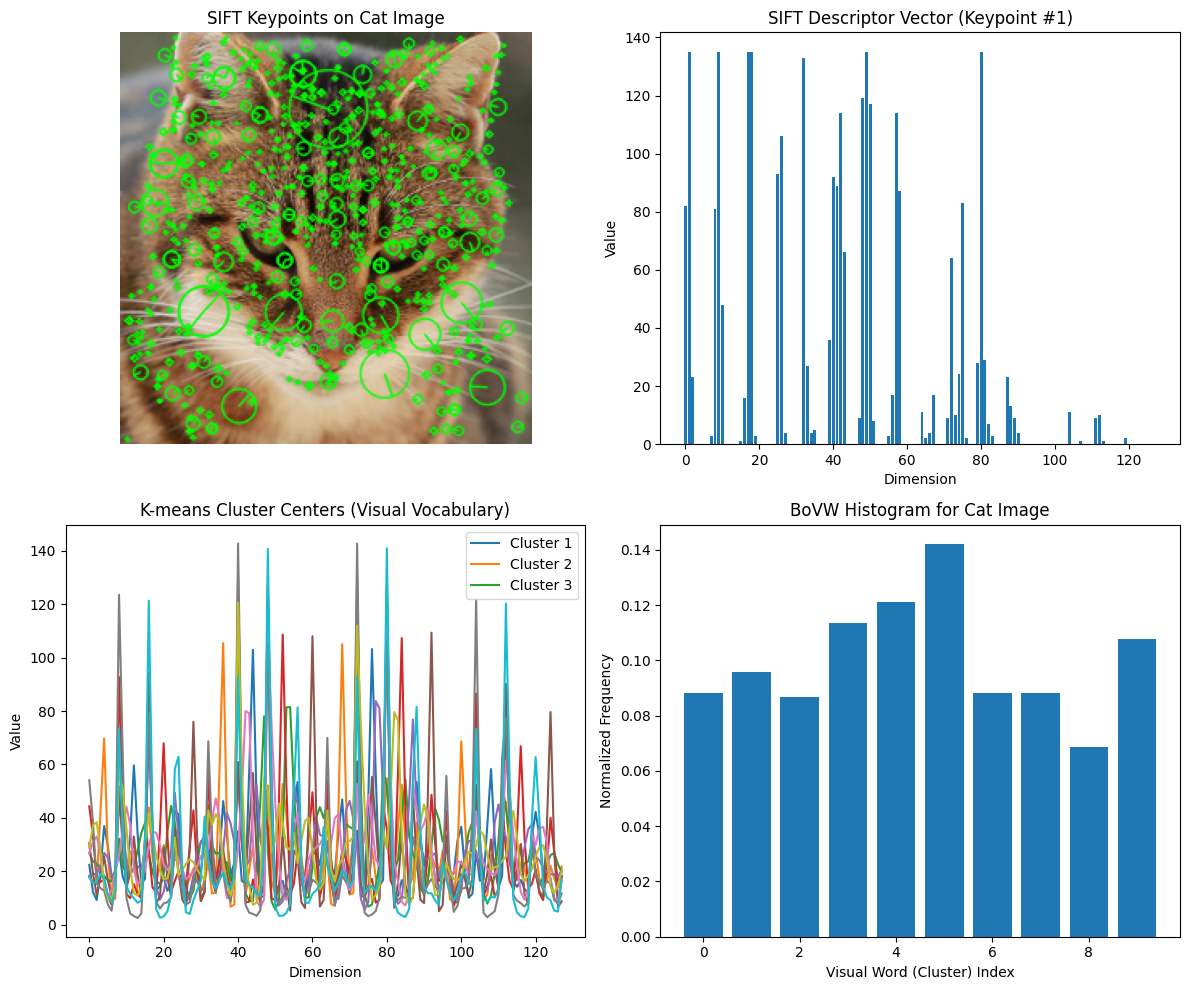

Image Label: cat
Number of keypoints detected: 669
SIFT descriptor shape: (669, 128)
K-means clusters: 10
Histogram shape: (10,)
Extracting SIFT features...


Extracting SIFT features:   0%|          | 0/400 [00:00<?, ?it/s]

Extracting SIFT features...


Extracting SIFT features:   0%|          | 0/100 [00:00<?, ?it/s]

Clustering 146533 descriptors into 100 clusters...
Creating BoVW features for training images...


Processing training features:   0%|          | 0/400 [00:00<?, ?it/s]

Creating BoVW features for validation images...


Processing validation features:   0%|          | 0/100 [00:00<?, ?it/s]

Training SVM classifier...
Predicting on validation set...


Making predictions:   0%|          | 0/100 [00:00<?, ?it/s]

Validation Accuracy: 0.7800
Classification Report:
              precision    recall  f1-score   support

         cat       0.74      0.86      0.80        50
         dog       0.83      0.70      0.76        50

    accuracy                           0.78       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.79      0.78      0.78       100

Confusion Matrix:
[[43  7]
 [15 35]]


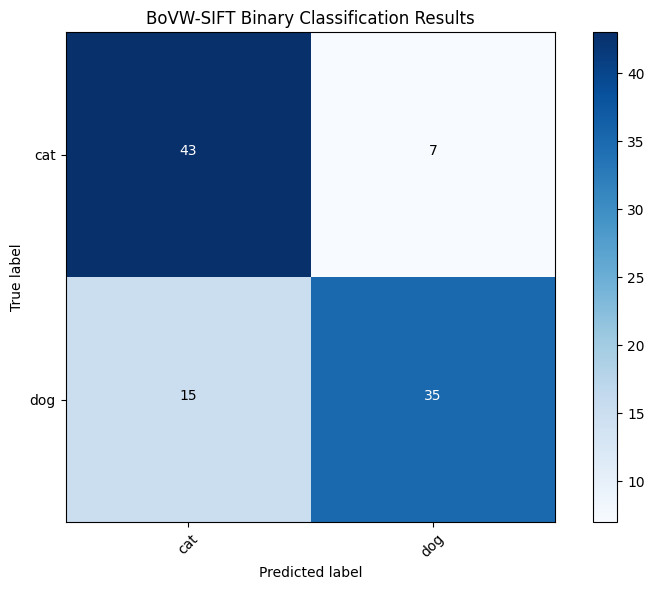

In [ ]:
svm, kmeans = main()

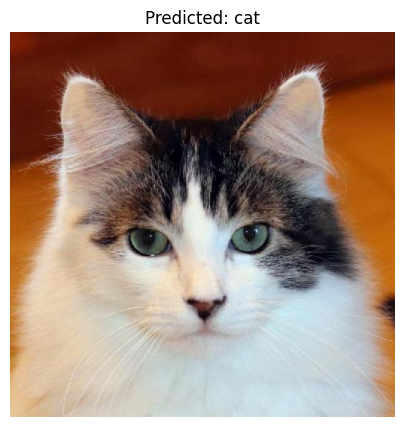

'cat'

In [ ]:
test_img_path = '/content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/val/cat/flickr_cat_000008.jpg'
predict_and_plot(test_img_path, svm, kmeans, n_clusters=100)

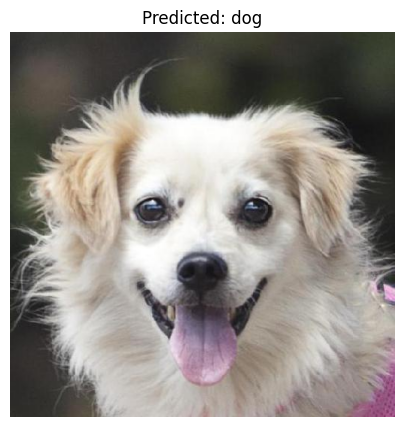

'dog'

In [ ]:
test_img_path = '/content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/val/dog/flickr_dog_000045.jpg'
predict_and_plot(test_img_path, svm, kmeans, n_clusters=100)

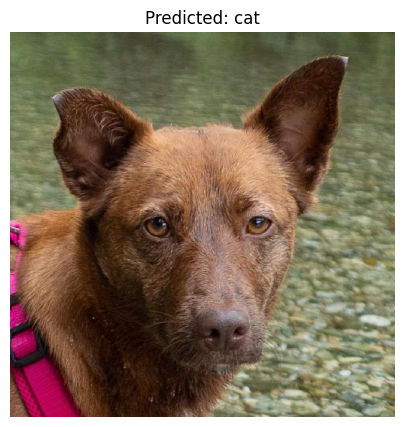

'cat'

In [ ]:
test_img_path = '/content/drive/MyDrive/CV_Final/face_dataset/animal_face_dataset/val/dog/flickr_dog_000043.jpg'
predict_and_plot(test_img_path, svm, kmeans, n_clusters=100)